In [204]:
import sys

# Add the paths that facenet is in
sys.path.insert(0, "../custom_facenet/src")
sys.path.insert(0, "../custom_facenet/src/align")

In [205]:
import os
import sklearn
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import detect_face
import facenet
import tensorflow as tf # NOTE: this has to use Tensorflow version 1.x
import numpy as np
import cv2
import scipy as sp
import glob
import copy
import dlib
import math
import time
from skimage import io
from pathlib import Path
%matplotlib inline

## Setup

In [206]:
MODEL_DIR = "20170216-091149"
image_paths = glob.glob("2faces/**/*.jpg")

## Visualize the people that are being clusters

In [207]:
def load_images(image_paths):
    images = []
    for image_path in image_paths:
        image = mpimg.imread(image_path)
        images.append(image)
    return(np.array(images))

images = load_images(image_paths)

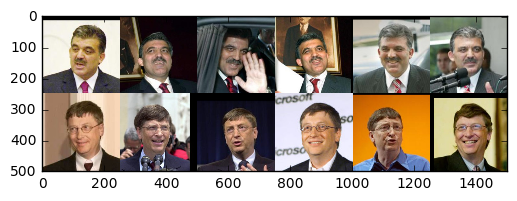

In [208]:
plt.imshow(np.vstack((np.hstack(images[0:6]), np.hstack(images[20:26]))))

In [209]:
class Face:
    """
    This is a data structure to store the faces and the relevant information to cluster it later on
    
    :: face_image is the image of the resized face
    :: image_path is the image path of the photo that the face was extracted from
    :: name is the name of the face and used to test our accuracy
    :: original_image_with_bounding_box is the original image with a box drawn around the face
    :: embedding is the 128 dimension embedding in the a unit sphere
    :: label is the cluster label that was assigned to this face
    """
    def __init__(self, image_path, resized_image_path, name = None, prewhitened_face_image = None,\
                 absolute_distance_neighbours = None, rank_order_neighbours = None,  \
                 original_image_with_bounding_box = None,\
                 embedding = None, label = None):
        
        self.image_path = image_path # this is the image path that contains the photo 
                                     # this face is located in            
        self.resized_image_path = resized_image_path
        self.name = name
        self.prewhitened_face_image = prewhitened_face_image
        self.absolute_distance_neighbours = absolute_distance_neighbours
        self.rank_order_neighbours = rank_order_neighbours
        self.original_image_with_bounding_box = original_image_with_bounding_box
        self.embedding = embedding
        self.label = label
    
    def __str__(self):
        return("Name: {}\nLabel: {}".format(self.name_of_face, self.label))

## Find the faces
The MTCNN to find the faces in an image, it works by using 3 neural networks feeding the output of one into the of the next one. Each neural network creates more refined bounding boxes for the face. This is this [link](https://kpzhang93.github.io/MTCNN_face_detection_alignment/index.html) for the paper and the code.

#### Find the faces with the MTCNN

In [210]:
def find_faces(image_paths):
    
    # Set the parameter values needed for MTCNN
    minsize = 20 # minimum size of face
    threshold = [ 0.6, 0.7, 0.7 ]  # three steps's threshold
    factor = 0.709 # scale factor used for the pyramid
    margin = 20 # the margin around the bboxes
    output_image_size = 160 # 160 x 160 is the image size that facenet requires
    
    # Get the image size
    sample_image = mpimg.imread(image_paths[0])
    img_size = sample_image.shape
    
    # Storage of all the faces 
    faces = []
    
    # Storage of the number of faces from each individual
    faces_dict = {}
    
    # Initialize the MTCNN networks
    with tf.Graph().as_default():
        ## TODO: GPU options
        # gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=<gpu_memory_fraction>)
        sess = tf.Session()
        with sess.as_default():
            pnet, rnet, onet = detect_face.create_mtcnn(sess, None)

        print("Total images: {}".format(len(image_paths)))
        for i, image_path in enumerate(image_paths):
            # Read in the image
            image = mpimg.imread(image_path)
            
            # Now find the bboxes
            bboxes,_ = detect_face.detect_face(image, minsize, pnet, rnet, onet, threshold, factor)
#             bboxes = bboxes[:, 0:4] # get the x1, y1, x2, y2 for the corners
            bboxes = bboxes[:1, 0:4] # only get the first bboxes for easier evaluation


            for j, bbox in enumerate(bboxes):

                # Apply margins while confining the bboxes to be contained 
                # within the dimensions of the image
                bbox[0] = np.maximum(bbox[0]-margin/2, 0)
                bbox[1] = np.maximum(bbox[1]-margin/2, 0)
                bbox[2] = np.minimum(bbox[2]+margin/2, img_size[1])
                bbox[3] = np.minimum(bbox[3]+margin/2, img_size[0])
                bbox = bbox.astype(np.int32)

                # Get the face
                face_image = image[bbox[1]:bbox[3], bbox[0]:bbox[2],:]

                # Resize the face to a size that facenet can use
                face_resized = sp.misc.imresize(face_image, (output_image_size, output_image_size), interp = 'bilinear')
                
                # Get the name of the face (for evaluation purposes)
                name = image_path.split("/")[1] 
                
                # Create the path to save the resized image for later use
                resized_image_file_path = image_path.split("/")
                resized_image_file_path[2] = image_path.split("/")[2].split(".")[0] + "_resized_face_{}.jpg".format(j+1)
                
                resized_image_file_path[0] = image_path.split("/")[0] + "_resized"
                
                resized_image_file_path = "/".join(resized_image_file_path)
                
                path = Path(resized_image_file_path)
                path.parent.mkdir(parents=True, exist_ok=True) 
                
                # Save the resized image
                sp.misc.imsave(resized_image_file_path, face_resized) 
                
                face = Face(image_path, resized_image_file_path, name)
               
                # Save the face for later to be used in evaluation of our algorithm
                if name not in faces_dict:
                    faces_dict[name] = [face]
                else:
                    faces_dict[name].append(face)
                    
                
                faces.append(face)
                
            
            print("Processed {}/{} images".format(i + 1, len(image_paths)), end = "\r")            
    return(np.array(faces), faces_dict)

In [211]:
faces, faces_dict = find_faces(image_paths)

Total images: 33


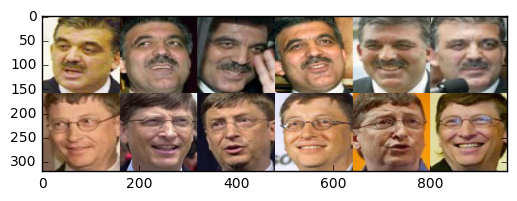

In [212]:
# Show the extracted faces
images = []
for face in faces:
    image = mpimg.imread(face.resized_image_path)
    images.append(image)
images = np.array(images)
plt.imshow(np.vstack((np.hstack(images[0:6]), np.hstack(images[20:26]))))

In [213]:
for name, _faces in faces_dict.items():
    print("Name: {}".format(name))
    print("Number of faces: {}".format(len(_faces)))

Name: Abdullah_Gul
Number of faces: 16
Name: Bill_Gates
Number of faces: 17


## Creating the face embeddings
The embeddings for the faces are created using FaceNet, the network that is used is the Resnet-Inception v1. Here is the [link](https://arxiv.org/pdf/1503.03832.pdf) to the original paper, and here is a [link](https://github.com/davidsandberg/facenet) the Github that has the pretrained model.

#### Load the embedding layer

In [214]:
def load_embedding_layer_for_facenet():
    # Now utilize facenet to find the embeddings of the faces
    # Get the save files for the models 
    meta_file, ckpt_file = facenet.get_model_filenames(MODEL_DIR)
    with tf.Graph().as_default():
        with tf.Session().as_default() as sess:
            model_dir_exp = os.path.expanduser(MODEL_DIR)
            print("importing graph")
            saver = tf.train.import_meta_graph(os.path.join(model_dir_exp, meta_file))
            print("restoring session")
            saver.restore(tf.get_default_session(), os.path.join(model_dir_exp, ckpt_file))
            images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
            embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
            phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
            embedding_layer = lambda img : sess.run(embeddings, feed_dict = {images_placeholder : img, phase_train_placeholder : False})
    return(embedding_layer)

In [215]:
# Note this will take a long time to load due to the size of the Inception-Resnet
embedding_layer = load_embedding_layer_for_facenet()

importing graph
restoring session


#### Assign the embeddings to the faces

In [216]:
def prewhiten(x):
    # just normalizing the image
    mean = np.mean(x) # mean of all elements
    std = np.std(x) # std of all elements
    std_adj = np.maximum(std, 1.0/np.sqrt(x.size)) # get the max between the std, and 1/sqrt(number_of_all_elements)
    y = np.multiply(np.subtract(x, mean), 1/std_adj)
    return(y)

def assign_embeddings(embedding_layer, faces, batch_size = 32):
    
    # Get the save files for the models
    n_images = len(faces)
    n_batches = int(np.ceil(float(n_images)/batch_size))
    embeddings = np.zeros((n_images, 128))
    face_images = []
    
    # First preprocess the faces
    for face in faces:
        face_image = mpimg.imread(face.resized_image_path)
        prewhitened_face_image = prewhiten(face_image)
        face_images.append(prewhitened_face_image)

    print("{} batch(es) of size {}".format(n_batches, batch_size))
    
    # Find the embeddings
    for i in range(n_batches):
        print("Processing batch {}/{}".format(i+1, n_batches), end = "\r")
        start = i * batch_size
        end = min((i + 1) * batch_size, n_images)

        # Get the embeddings
        embeddings[start:end, :] = embedding_layer(face_images[start:end])
        
    # Assign the embeddings 
    for i, face in enumerate(faces):
        face.embedding = embeddings[i]

In [217]:
# Assign the embeddings for the faces
start = time.time()
assign_embeddings(embedding_layer, faces)
duration = time.time() - start
print()
print(np.around(duration, 2))

2 batch(es) of size 32
Processing batch 2/2
5.47


## Visualizing the embeddings
As the embeddings are in 128 dimensional space it is impossible for us to visualize. We could use Principle Components Analysis (PCA) to reduce the dimensionality of the embeddings. The reason that it isn't used is two-fold:
1. It is a linear projection which means that what it can model is quite limited
2. It preserves global distances which aren't that interesting for clustering and may make the faces harder to cluster. Furthermore, we are only interested in the local distances (in high dimensions) and PCA does not capture the local distances effectively

As a result of these two factors, it would make more sense to use t-Stochastic Neighbour Embedding (tSNE) which is another dimensionality reduction technique. It can learn a non-linear projection, and it has a hyperparameter which determines how much weight is given to preserving the local distance (although preserving the local distance would mean losing information about the global distance). Therefore, the hyperparameter can be tuned such that the local distances are kept, which is what we are interested in.

Although in reality it doesn't really matter THAT much since the embeddings created by FaceNet are so robust. Moreover, this is just for visualization when the clustering algorithm is run the faces are still clustered in 128 dimensional space.

<h3><font color='red'>Note that tSNE was tuned for the dataset with only 2 different kinds of faces so it will not work with 120 faces</font></h3>

In [218]:
# Get the embeddings in an array for easier clustering
face_embeddings = np.zeros((len(faces), 128))
for i, face in enumerate(faces):
    face_embeddings[i, :] = face.embedding

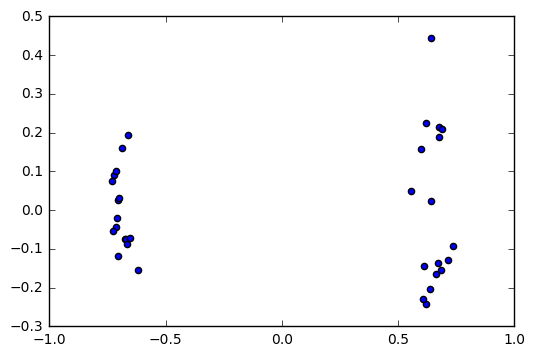

In [219]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
face_embeddings_pca = pca.fit_transform(face_embeddings)
x = [face_embedding[0] for face_embedding in face_embeddings_pca]
y = [face_embedding[1] for face_embedding in face_embeddings_pca] 
plt.scatter(x, y)

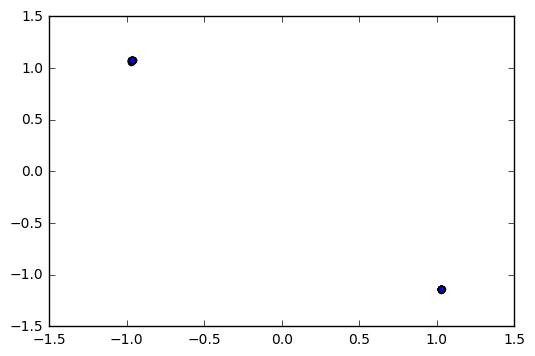

In [220]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, perplexity = 15, learning_rate= 1)
face_embeddings_tsne = tsne.fit_transform(face_embeddings)
x = [face_embedding[0] for face_embedding in face_embeddings_tsne]
y = [face_embedding[1] for face_embedding in face_embeddings_tsne] 
plt.scatter(x, y)

## Clustering the embeddings
There are many clustering algorithms that can be used, although we have two major constraints.
1. The number of clusters aren't known before clustering therefore we can't use clustering algorithms that need to know the number of clusters beforehand (such as the commonly used [K-means](https://en.wikipedia.org/wiki/K-means_clustering)).
2. The time complexity of the clustering algorithm. Many clustering algorithms have runtimes greater than O(N^2). Although O(N^2) is bad it can be thought of as the naive lower bound for clustering algorithms (absent of some stochastic/approximation of the data during the clustering phase) due to the adjacency distance matrix that has to be computed. So ideally we would want an algorithm that has O(N^2) run time.

3. Even though the embeddings are in 128 dimensional space, they are likely to follow the Manifold Assumption whereby the the majority of the information for the embedding can be represented in a lower dimensional space. Which means that the standard Euclidean distance can be used (as it isn't affected by the [curse of dimensionalty](https://en.wikipedia.org/wiki/Curse_of_dimensionality) as much).

If we are only using the sci-kit learn library for cluster it doesn't really leave us with any clustering algorithms unless we want to do a search over the number of clusters in the dataset (which would be prohibitively expensive as the number of faces increases). Therefore, the clustering algorithm that will be used is the [rank-order](https://pdfs.semanticscholar.org/efd6/4b7641bea8ca536f4e179be6e2dd25d519d6.pdf) clustering algorithm which is a algorithm developed by a joint research group between Tsinghua University and Microsoft.

### Clustering based solely on using as the rank-order distance between embeddings

#### Calculating the L1 distance used to create the rank-order distance

In [221]:
import scipy

class Neighbour:
    def __init__(self, entity, distance):
        self.entity = entity
        self.distance = distance

In [222]:
# Create nearest neighbours list of absolute distance
def assign_absolute_distance_neighbours_for_faces(faces):
    for i, face1 in enumerate(faces):
        nearest_neighbour = []
        
        print("Calculating neighbours for face {}/{}".format(i + 1, len(faces)), end = "\r")
        for j, face2 in enumerate(faces):
#             print()
            distance = np.linalg.norm(face1.embedding - face2.embedding, ord = 1)
            neighbour = Neighbour(face2, distance)
            nearest_neighbour.append(neighbour)
        nearest_neighbour.sort(key = lambda x: x.distance)
        face1.absolute_distance_neighbours = nearest_neighbour 

In [223]:
assign_absolute_distance_neighbours_for_faces(faces)
# for abs_neighbour in faces[0].absolute_distance_neighbours:
#     print(abs_neighbour.entity.name)
#     print(abs_neighbour.distance)

#### Define the rank-order distance metric

In [224]:
def find_rank_order(entity1, entity2):
    
    distance_entity1_entity2, num_neighbours_entity1 = find_asym_rank_order(entity1, entity2)
    distance_entity2_entity1, num_neighbours_entity2 = find_asym_rank_order(entity2, entity1)
    min_neighbours = min(num_neighbours_entity1, num_neighbours_entity2)
    return((distance_entity1_entity2 + distance_entity2_entity1)/min_neighbours)

def find_asym_rank_order(entity1, entity2):
    penalty = 0
    for i, neighbour1 in enumerate(entity1.absolute_distance_neighbours):
#         print("i is: {}".format(i))
        for j, neighbour2 in enumerate(entity2.absolute_distance_neighbours):
#             print("j is: {}".format(j))
            if neighbour1.entity is neighbour2.entity:
#                 print("found match")
#                 print("add penalty: {}".format(j))
                if j == 0: # this means that we found the rank of entity2 in entity1's neighbouts
                    return(penalty, i + 1)
                else:
                    penalty += j
#         print("penalty is: {}".format(penalty))
    return(penalty, i+1)

In [225]:
def assign_rank_order(entities):
    for entity1 in entities:
        nearest_neighbours = []
        
        for entity2 in entities:

            # Get rank order distance between entity1 and face 2
            rank_order = find_rank_order(entity1, entity2)
            nearest_neighbours.append(Neighbour(entity2, rank_order))

        nearest_neighbours.sort(key = lambda x : x.distance)
        entity1.rank_order_neighbours = nearest_neighbours 

In [226]:
assign_rank_order(faces)
# for neighbour in faces[0].rank_order_neighbours:
#     print(neighbour.entity.name)
#     print(neighbour.distance)

In [227]:
# Now lets see the top five neighbours for a randomly chosen face
import random
def peek_at_top_k_neighbours_for_face(face, top_k):
    """
    Look at the first num_faces faces for each of the top_k nearest neighbours from the specified face
    """
    top_k = top_k if top_k < len(face.absolute_distance_neighbours) else len(face.absolute_distance_neighbours)

    f, ax = plt.subplots(1, top_k, figsize = (15, 15))
    
    for i, neighbour in enumerate(face.absolute_distance_neighbours[0:top_k]):
        if i == 0:
            ax[i].set_title("Original Cluster")
            ax[i].imshow(mpimg.imread(neighbour.entity.resized_image_path))
        else:
            distance = str(np.around(neighbour.distance, 2))
            ax[i].set_title("L1 Distance: {}".format(distance))
            ax[i].imshow(mpimg.imread(neighbour.entity.resized_image_path))
    plt.tight_layout()

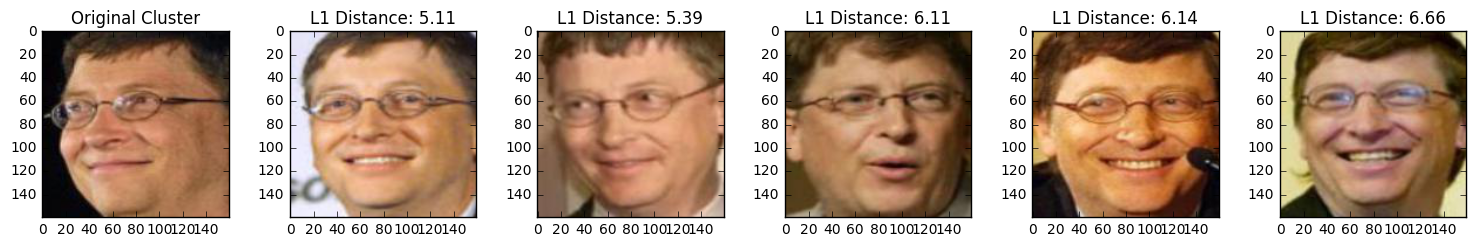

In [228]:
# Plot the neighbours of a random face
top_k = 6
face = faces[random.randint(0, len(faces) - 1)]
peek_at_top_k_neighbours_for_face(face, top_k)

### Clustering using Cluster-Level Rank-Order Distance, and also a Cluster-Level Normalized Distance. 
Clustering by just using the rank-order distnace for embeddings isn't very useful due to the method that the embeddings of the faces are created. Faces that have different poses, lightning, and etc will affect where the embedding is situated in the 128 dimension space. Therefore, there will be many small clusters of the same face. 

In this section I will explore a better clustering method whereby we have a rank-order distance between clusters which is most robust to outliers and changes in poses, lighting, and etc.

#### Setting up for the clustering algorithm
First though we have to define a Cluster-Level Rank-Order Distance, and also a Cluster-Level Normalized Distance.

In [229]:
class Cluster:
    def __init__(self):
        self.faces = list()
        self.absolute_distance_neighbours = None
        self.rank_order_neighbours = None
        self.normalized_distance = None
        self.majority_face = None
        self.num_of_majority_face = None
        
    def faces_in_cluster(self):
        faces_dict = {}
        for face in self.faces:
            if face.name not in faces_dict.keys():
                faces_dict[face.name] = 1
            else:
                faces_dict[face.name] += 1
        
        return(faces_dict)
                
    def debug(self):
        print("Faces in cluster:")
        for face in self.faces:
            print(face.name)
        
#         print("Absolute distance neighbours:")
#         for neighbour in self.absolute_distance_neighbours:
#             print(absolute_distance_neighbours.)
        

In [230]:
# Assigning each face to a cluster
def initial_cluster_creation(faces):
    clusters = []
    for face in faces:
        cluster = Cluster() 
        cluster.faces.append(face)
        clusters.append(cluster)
    return(clusters)

In [231]:
clusters = initial_cluster_creation(faces) 

#### Define/Calculate the nearest distance between two clusters

In [232]:
# Now we need to find the nearest neighbours for each of the vectors
# Note here that even though it looks like it's O(N^4) it's only N(O^2) due to the fact
# we really are only iterating through the faces

def find_nearest_distance_between_clusters(cluster1, cluster2):
    nearest_distance = sys.float_info.max
    for face1 in cluster1.faces:
        for face2 in cluster2.faces:
            distance = np.linalg.norm(face1.embedding - face2.embedding, ord = 1)
            
            if distance < nearest_distance: 
                nearest_distance = distance
                
            # If there is a distance of 0 then there is no need to continue
            if distance == 0:
                return(0)
    return(nearest_distance)
            
            
def assign_absolute_distance_neighbours_for_clusters(clusters):
    for i, cluster1 in enumerate(clusters):
        nearest_neighbours = []
        for j, cluster2 in enumerate(clusters):
            distance = find_nearest_distance_between_clusters(cluster1, cluster2)
#             print("Calculating neighbour {}/{} for cluster {}".format(j + 1, len(faces), i + 1), end = "\r")

            neighbour = Neighbour(cluster2, distance)
            nearest_neighbours.append(neighbour)
        nearest_neighbours.sort(key = lambda x: x.distance)
        cluster1.absolute_distance_neighbours = nearest_neighbours

In [233]:
# Verify that our cluster distance assignmnet is working. Uf it is then the first cluster should give us the same
# results as the first face above since as of right now each face is a cluster
assign_absolute_distance_neighbours_for_clusters(clusters)

# for abs_cluster_neighbour in clusters[0].absolute_distance_neighbours:
#     print(abs_cluster_neighbour.entity.faces[0].name)
#     print(abs_cluster_neighbour.distance)

#### Cluster Level Rank Order distance

In [234]:
assign_rank_order(clusters)

In [235]:
def peek_at_top_k_neighbours_for_cluster(cluster, top_k, num_faces):
    """
    Look at the first num_faces faces for each of the top_k nearest neighbours from the specified cluster
    """
    top_k = top_k if top_k < len(cluster.absolute_distance_neighbours) else len(cluster.absolute_distance_neighbours)
    num_faces = num_faces if 1 < num_faces else 2

    f, ax = plt.subplots(top_k, num_faces, figsize = (15, 15))
    
    for i, neighbour in enumerate(cluster.absolute_distance_neighbours[0:top_k]):
        for j, face_in_cluster in enumerate(neighbour.entity.faces[0:num_faces]):
            if i == 0:
                ax[i][j].set_title("Original Cluster")
                ax[i][j].imshow(mpimg.imread(face_in_cluster.resized_image_path))
            else:
                distance = str(np.around(neighbour.distance, 2))
                ax[i][j].set_title("L1 Distance: {}".format(distance))
                ax[i][j].imshow(mpimg.imread(face_in_cluster.resized_image_path)) 
    plt.tight_layout()

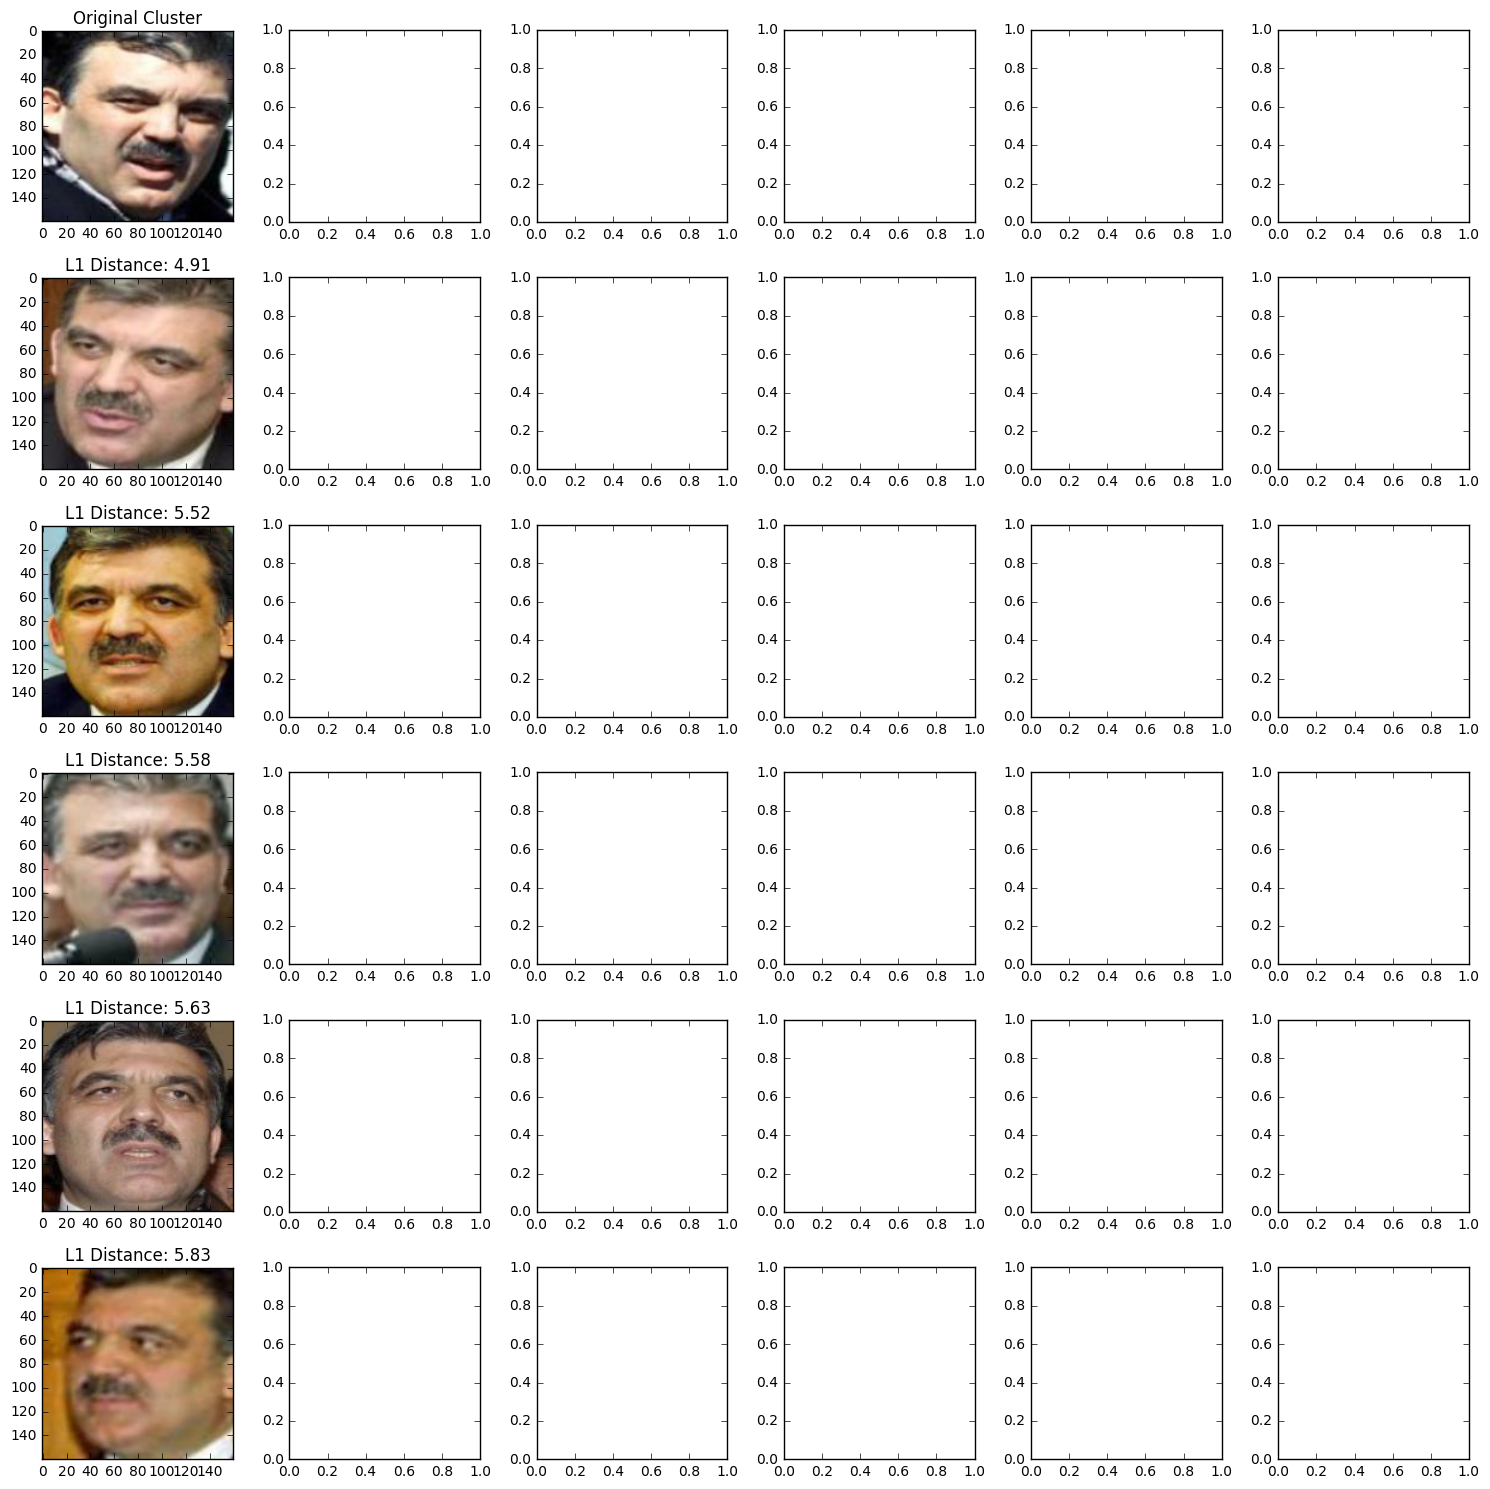

In [236]:
# Verify that we are assigned the rank order distance correctly for clusters, if we have it should be the 
# same as the rank order distance for faces
import random
top_k = 6
num_faces = 6
peek_at_top_k_neighbours_for_cluster(clusters[random.randint(0, len(clusters) - 1)], top_k, num_faces)

#### Cluster Level Normalized Distance

In [237]:
def find_normalized_distance_between_clusters(cluster1, cluster2, K = 9):
    all_faces_in_clusters = cluster1.faces + cluster2.faces
    normalized_distance = 0

    for face in all_faces_in_clusters:
        total_absolute_distance_for_top_K_neighbours = sum([neighbour.distance for neighbour in face.absolute_distance_neighbours[0:K]]) 
#         print("Face: {}".format(face.name))
#         print("Total distance to top {}: {}".format(K, total_absolute_distance_for_top_K_neighbours))
        normalized_distance += total_absolute_distance_for_top_K_neighbours
    
#     print("Normalized distance: {}".format(normalized_distance))
    # Now average the distance
    K = min(len(face.absolute_distance_neighbours), K)
    normalized_distance = normalized_distance/K
    
    # then divide by all the faces in the cluster
    normalized_distance = normalized_distance/len(all_faces_in_clusters)
    normalized_distance = (1/normalized_distance) * find_nearest_distance_between_clusters(cluster1, cluster2)
    return(normalized_distance)

def find_rank_order_distance_between_clusters(cluster1, cluster2):
    return(find_rank_order(cluster1, cluster2))            

#### Clustering Algorithm 

In [238]:
import networkx as nx
import time

In [239]:
# Setup the faces
def setup(image_paths):
    start = time.time()
    print("-" * 50)
    print("Finding and aligning the faces")
    faces, face_count_dict = find_faces(image_paths)
    print()
    print("Finding and aligning the faces took: {} seconds".format(np.around(time.time() - start, 2)))
    
    print("-" * 50)         
    print("Creating the embeddings")
    start = time.time()
    assign_embeddings(embedding_layer, faces)
    print()
    print("Creating the embeddings took {} seconds".format(np.around(time.time() - start, 2)))
          
    """
    TODO: Create some persistent storage for the embeddings of the faces, so that when new images are added 
          the faces don't have to be re-found/aligned and embedded (which takes a lot of time) and only the 
          absolute distances need to be calculated
    """ 
          
    print("-" * 50)
    print("Assigning the distance between faces")
    start = time.time()
    assign_absolute_distance_neighbours_for_faces(faces)
    print()
    print("Assigning the distances took {} seconds". format(np.around(time.time() - start, 2)))
    print("-" * 50)
#     print("Finding, aligning, and creating the embeddings for {} images, with a total of {} faces took: {} seconds".\
#           format(len(image_paths), len(faces), np.around(time.time()-start, 2)))
    return(faces, face_count_dict)

In [240]:
image_paths = glob.glob("2faces/**/*.jpg")
faces, faces_dict = setup(image_paths)

--------------------------------------------------
Finding and aligning the faces
Total images: 33
Processed 33/33 images
Finding and aligning the faces took: 5.71 seconds
--------------------------------------------------
Creating the embeddings
2 batch(es) of size 32
Processing batch 2/2
Creating the embeddings took 4.62 seconds
--------------------------------------------------
Assigning the distance between faces
Calculating neighbours for face 33/33
Assigning the distances took 0.01 seconds
--------------------------------------------------


In [241]:
def find_clusters(faces):
    clusters = initial_cluster_creation(faces)
    assign_absolute_distance_neighbours_for_clusters(clusters)
    t = 14
    prev_cluster_number = len(clusters)
    num_created_clusters = prev_cluster_number
    is_initialized = False

    while (not is_initialized) or (num_created_clusters):
        print("Number of clusters in this iteration: {}".format(len(clusters)))
    #     print(clusters)

        G = nx.Graph()
        for cluster in clusters:
            G.add_node(cluster)
        num_pairs = sum(range(len(clusters) + 1))
        processed_pairs = 0
        
    #     Find the candidate merging pairs
        for i, cluster1 in enumerate(clusters):

            # Order does not matter of the clusters since rank_order_distance and normalized_distance is symmetric
            # so we can get away with only calculating half of the required pairs
            for j, cluster2 in enumerate(clusters[i:]):
                processed_pairs += 1
                print("Processed {}/{} pairs".format(processed_pairs, num_pairs), end="\r")
                # No need to merge with yourself 
                if cluster1 is cluster2:
                    continue
                else: 
                    normalized_distance = find_normalized_distance_between_clusters(cluster1, cluster2)
                    if (normalized_distance >= 1):
                        continue
                    rank_order_distance = find_rank_order_distance_between_clusters(cluster1, cluster2)
                    if (rank_order_distance >= t):
                        continue
                    G.add_edge(cluster1, cluster2)
        print()     
        clusters = []
        for _clusters in nx.connected_components(G):
            new_cluster = Cluster()
            for cluster in _clusters:
                for face in cluster.faces:
                    new_cluster.faces.append(face)
            clusters.append(new_cluster)


        current_cluster_number = len(clusters)
        num_created_clusters = prev_cluster_number - current_cluster_number
        prev_cluster_number = current_cluster_number

        
        # Recalculate the distance between clusters
#         print("assigning absolute distances")
        assign_absolute_distance_neighbours_for_clusters(clusters)
        
        

#         for i, cluster in enumerate(clusters):
#             print("Cluster: {}".format(i))
#             print("Faces in cluster")
#             for face in cluster.faces:
#                 print(face.name) 
#             print("Distances to other clusters")
#             for neighbour in cluster.absolute_distance_neighbours:
#                 print(neighbour.distance)

        # Count the number of faces
#         num_faces = 0
#         for cluster in clusters:
#             for face in cluster.faces:
#                 num_faces += 1
#         print("Number of faces: {}".format(num_faces))

        is_initialized = True

    # Now that the clusters have been created, separate them into clusters that have one face
    # and clusters that have more than one face
    unmatched_clusters = []
    matched_clusters = []

    for cluster in clusters:
        if len(cluster.faces) == 1:
            unmatched_clusters.append(cluster)
        else:
            matched_clusters.append(cluster)
            
    matched_clusters.sort(key = lambda x: len(x.faces), reverse = True)
            
    return(matched_clusters, unmatched_clusters)

In [242]:
matched_clusters, unmatched_clusters = find_clusters(faces)

Number of clusters in this iteration: 33
Processed 561/561 pairs
Number of clusters in this iteration: 23
Processed 276/276 pairs
Number of clusters in this iteration: 21
Processed 231/231 pairs
Number of clusters in this iteration: 20
Processed 210/210 pairs


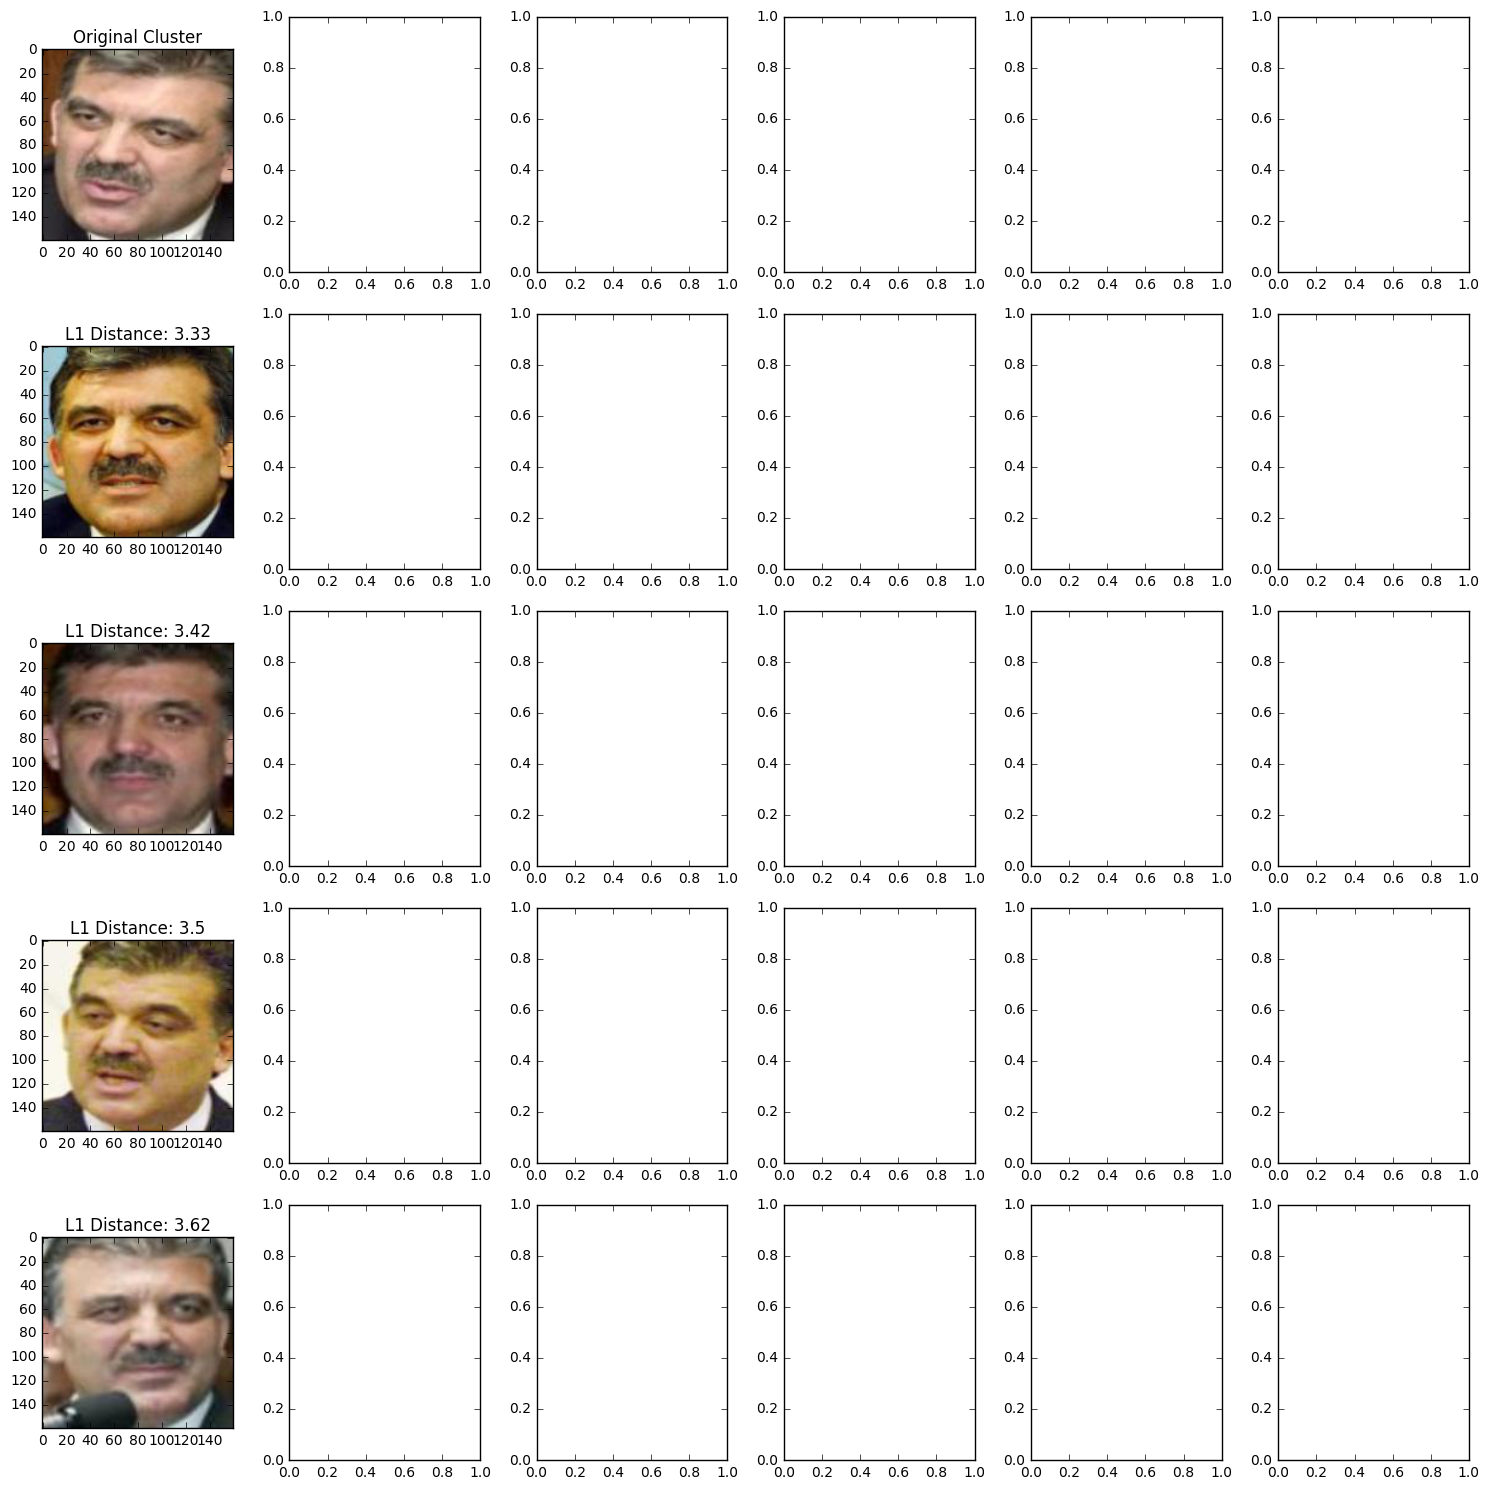

In [243]:
index = random.randint(0, len(matched_clusters) - 1)
top_k = 5
num_faces = 6
peek_at_top_k_neighbours_for_cluster(clusters[index], top_k, num_faces)

In [244]:
# Show the faces in each cluster
def peek_at_biggest_k_clusters(clusters, num_clusters, num_faces):
    num_clusters = num_clusters if num_clusters < len(clusters) else len(clusters)
    num_faces = num_faces if 1 < num_faces else 2
    f, ax = plt.subplots(num_clusters, num_faces, figsize = (15, 15))
    for i, cluster in enumerate(matched_clusters[0:num_clusters]):
        for j, face in enumerate(cluster.faces[0:num_faces]):
            ax[i][j].set_title("Faces in cluster: {}".format(len(cluster.faces)))
            ax[i][j].imshow(mpimg.imread(face.resized_image_path))
    plt.tight_layout()

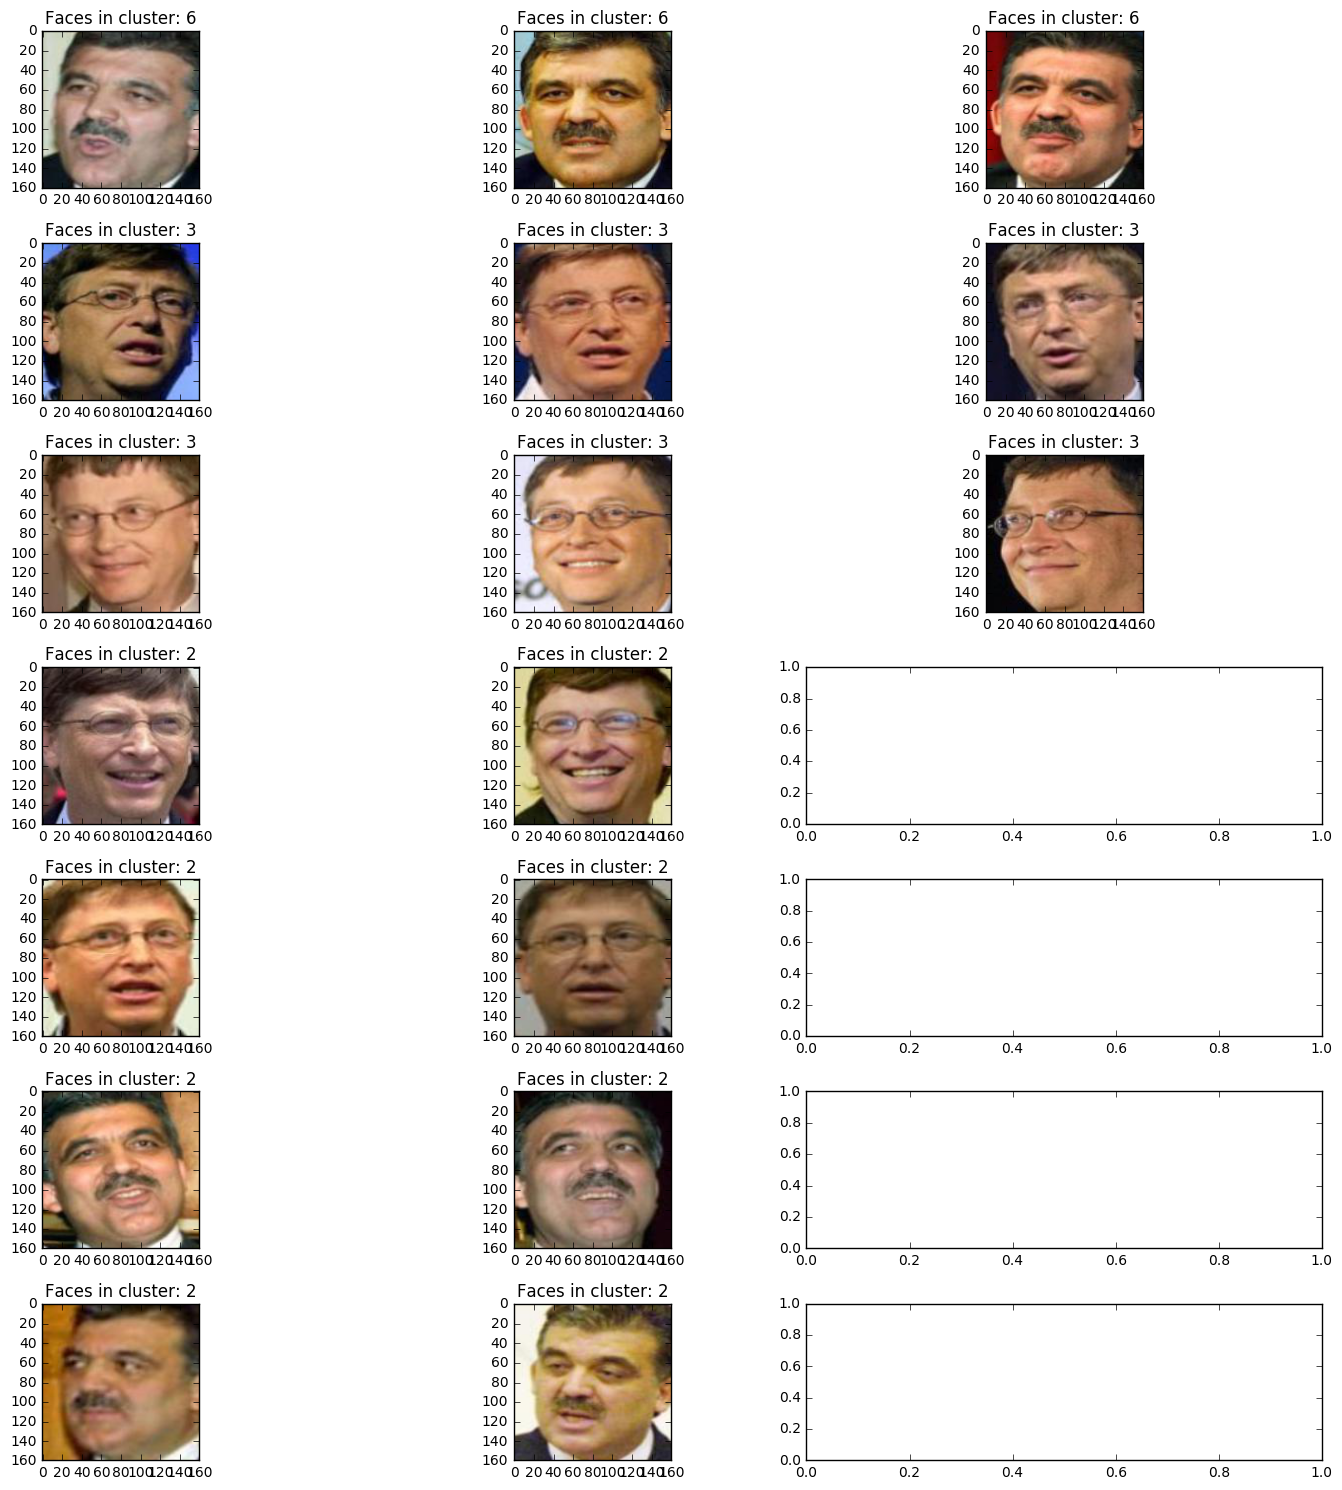

In [245]:
num_clusters = 10
num_faces = 3
peek_at_biggest_k_clusters(matched_clusters, num_clusters, num_faces)

## Now that we see it works with 2 faces lets scale it up to 120 faces

In [246]:
# Setup the faces
image_paths = glob.glob("120faces/**/*.jpg")
# faces, face_count_dict = setup(image_paths)

In [247]:
faces, faces_dict = setup(image_paths)

--------------------------------------------------
Finding and aligning the faces
Total images: 234
Processed 234/234 images
Finding and aligning the faces took: 28.32 seconds
--------------------------------------------------
Creating the embeddings
8 batch(es) of size 32
Processing batch 8/8
Creating the embeddings took 30.44 seconds
--------------------------------------------------
Assigning the distance between faces
Calculating neighbours for face 234/234
Assigning the distances took 0.61 seconds
--------------------------------------------------


In [248]:
matched_clusters, unmatched_clusters = find_clusters(faces)

Number of clusters in this iteration: 234
Processed 27495/27495 pairs
Number of clusters in this iteration: 139
Processed 9730/9730 pairs
Number of clusters in this iteration: 136
Processed 9316/9316 pairs
Number of clusters in this iteration: 135
Processed 9180/9180 pairs


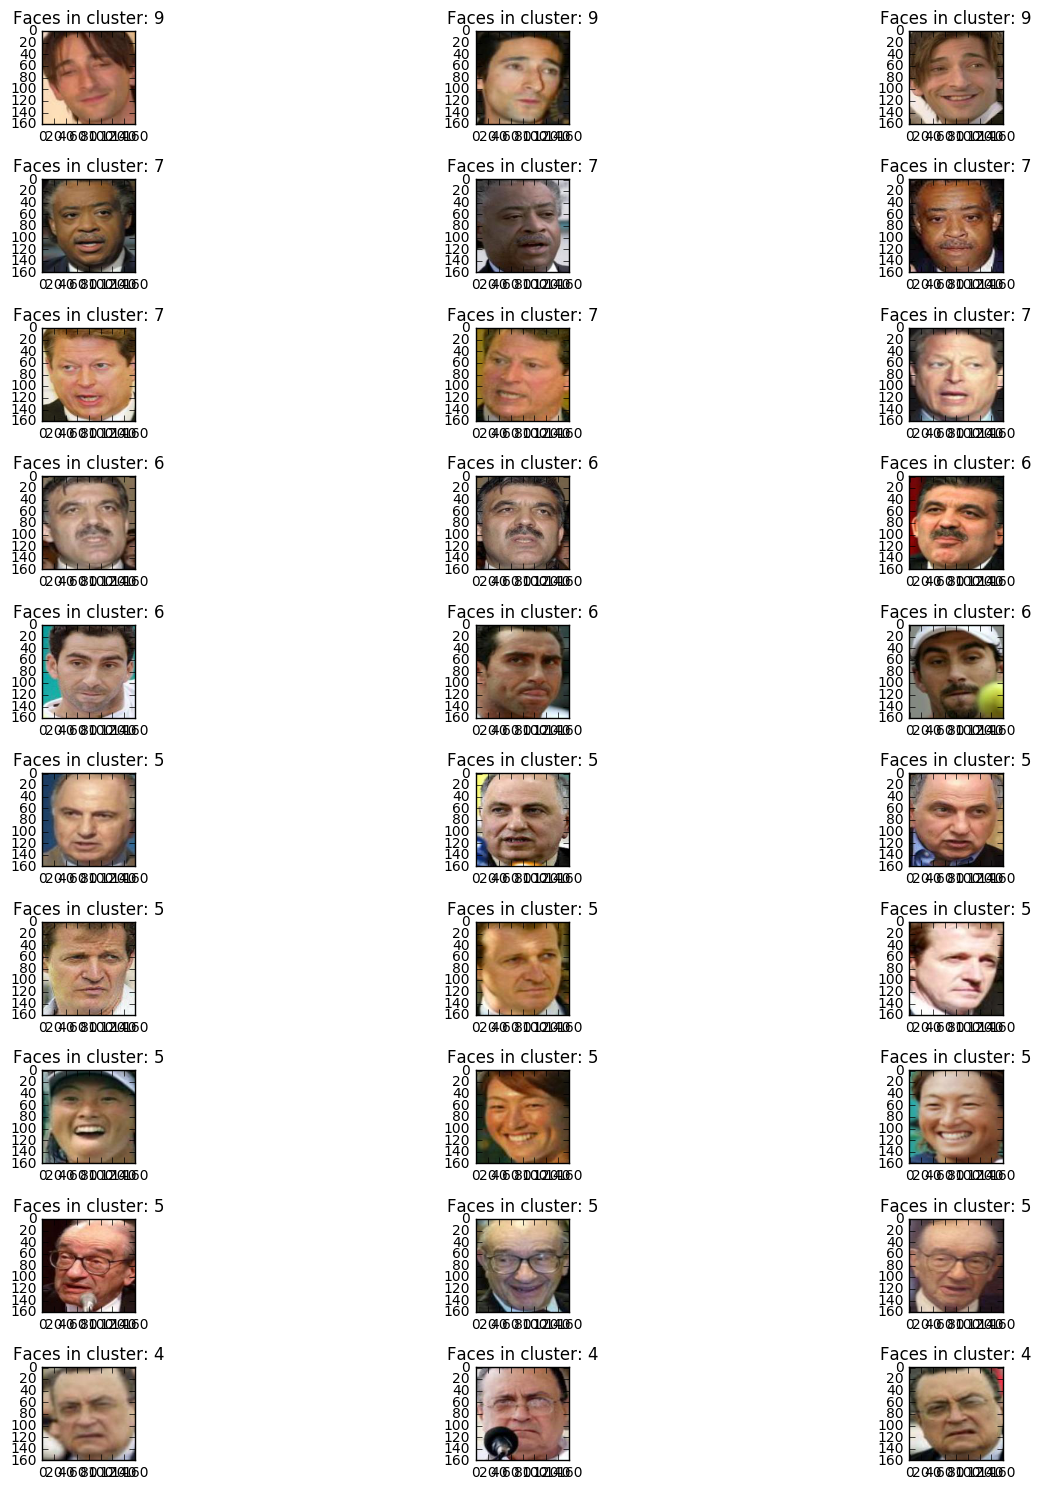

In [249]:
num_clusters = 10
num_faces = 3
peek_at_biggest_k_clusters(matched_clusters, num_clusters, num_faces)

## Evaluating the performance

#### Performance of the clustering on identifying single faces in the data set
Since the labels for the faces are readily available it is easy for us to see the performance of our clusters. We first look at the clusters that only have one individuals and see how robust our clustering algorithm is. This is used to test the robustness of our clustering algorithm because faces that only appear once in a photo album can be considered as "noise". We obviously don't want to cluster faces that only appear once with other faces so this is the first thing that we investigate 

In [250]:
# First get the names of the faces that only appear once
single_faces = []
for name, faces_ in faces_dict.items():
    if len(faces_) == 1:
        single_faces.append(faces_[0])

In [251]:
# Now get our unmatched clusters which are clusters that only contain one face
single_cluster_faces = []
for cluster in unmatched_clusters:
    single_cluster_faces.append(cluster.faces[0])
# print(single_cluster_faces)

In [252]:
identified_single_faces = []
unindentified_single_faces = []
for face in single_faces:
    if face in single_cluster_faces:
        identified_single_faces.append(face)
    else:
        unindentified_single_faces.append(face)        

In [253]:
print("Percentage of single faces correctly clustered as single faces is {}%".format(len(identified_single_faces)/len(single_faces)*100))

Percentage of single faces correctly clustered as single faces is 96.25%


#### Performance of the clustering on faces that appear more than once
As there are some faces appear more than once in the data, we want to see if the majority of them are being represented in one single big cluster, and not various small clusters

In [254]:
# First sort the clusters by name for easier evaluation
def assign_majority_face_for_cluster(clusters):
    for cluster in clusters:
        faces_dict = cluster.faces_in_cluster()
        majority_face = max(faces_dict, key=lambda k: faces_dict[k])
        cluster.majority_face = majority_face
        cluster.num_of_majority_face = faces_dict[majority_face]

In [255]:
assign_majority_face_for_cluster(matched_clusters)
matched_clusters.sort(key = lambda x: x.majority_face)

In [256]:
for cluster_ in matched_clusters:
    majority_face = cluster_.majority_face
    num_of_majority_face = cluster_.num_of_majority_face
    num_of_faces_in_cluster = len(cluster_.faces)
    print("-"  * 50)
    print("Cluster has {}/{} from {}".format(num_of_majority_face, num_of_faces_in_cluster, majority_face))
    print("Cluster contains {}/{} faces from {} in dataset".format(num_of_majority_face, \
                                                                   len(faces_dict[cluster_.majority_face]),\
                                                                   majority_face))

--------------------------------------------------
Cluster has 1/2 from Aaron_Patterson
Cluster contains 1/1 faces from Aaron_Patterson in dataset
--------------------------------------------------
Cluster has 4/4 from Aaron_Peirsol
Cluster contains 4/4 faces from Aaron_Peirsol in dataset
--------------------------------------------------
Cluster has 2/2 from Aaron_Sorkin
Cluster contains 2/2 faces from Aaron_Sorkin in dataset
--------------------------------------------------
Cluster has 4/4 from Abdoulaye_Wade
Cluster contains 4/4 faces from Abdoulaye_Wade in dataset
--------------------------------------------------
Cluster has 4/4 from Abdullah
Cluster contains 4/4 faces from Abdullah in dataset
--------------------------------------------------
Cluster has 6/6 from Abdullah_Gul
Cluster contains 6/19 faces from Abdullah_Gul in dataset
--------------------------------------------------
Cluster has 2/2 from Abdullah_Gul
Cluster contains 2/19 faces from Abdullah_Gul in dataset
-------